# Report for Ratings-Results

This report can be used to get an overview on the state of the evaluation.<br/>
It pulls the current ratings from firebase and uses different aggregations in order to create a number of visualizations and statistics.

### Pulling the data

In [15]:
import report

pull_data = True

if pull_data:
    report.create_report_files(
        "../keys/gs-on-a-budget-firebase-adminsdk-63ws0-509fffaf5f.json",
        "ratings.xlsx",
        "pairs.xlsx",
    )

### Loading and displaying the raw data

In [16]:
import pandas as pd

pairs = pd.read_excel("./pairs.xlsx")
pairs.columns.values

array(['Unnamed: 0', 'rotation', 'model_2', 'model_1', 'initial_distance',
       'size', 'fov_y', 'dataset_name', 'position', 'high_detail',
       'dataset', 'aspect', 'n_ratings', 'id'], dtype=object)

In [17]:
ratings = pd.read_excel("./ratings.xlsx")
ratings.columns.values

array(['Unnamed: 0', 'rating_1', 'user_id', 'pair_id', 'rating_2', 'id'],
      dtype=object)

### How many ratings are there per pair?

In [18]:
ratings_count_computed = ratings.groupby("pair_id")["id"].count()
df_ratings_count_computed = pd.DataFrame.from_dict({
    "pair_id": ratings_count_computed.index,
    "count": ratings_count_computed.values
}).sort_values("count", ascending=False)
df_ratings_count_computed

,pair_id,count
0,0Qbwb7Lis9pOLUVOSIrO,1
1,0YwyBZxWsQpHsGv8LS61,1
2,0bIsWmiOeRXEyKdMrHB1,1
3,1SUpmaSAQQNMdD8FibPB,1
4,2kRptcQx5PSo54pmymCi,1
5,2yLwlpCr3EttnrWODivG,1
6,3BPbSeLlA1pP4U3oOUfy,1
7,5C5kkshRarmXiRx92JRx,1


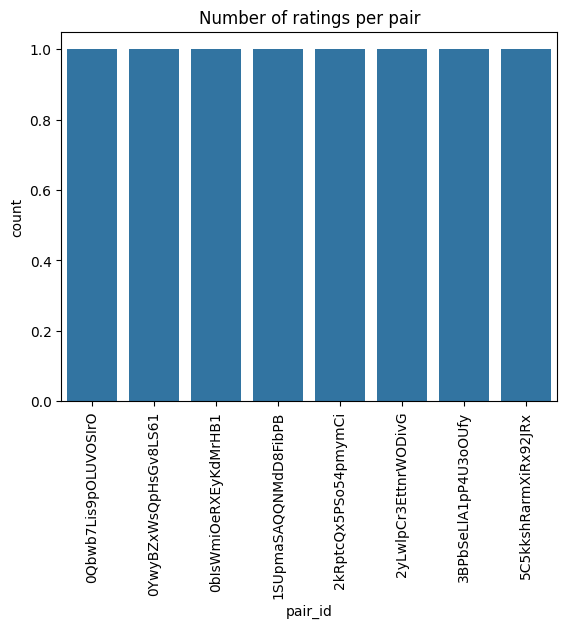

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.barplot(df_ratings_count_computed, x="pair_id", y="count")
plt.xticks(rotation=90)
plt.title("Number of ratings per pair")
plt.show()

In [34]:
# Check what percentage of pairs has been covered
print(f"{df_ratings_count_computed.shape[0]}/{pairs.shape[0]} pairs have been covered. Thats {round(df_ratings_count_computed.shape[0] / pairs.shape[0] * 100, 2)}%.")

8/252 pairs have been covered. Thats 3.17%


In [20]:
# sanity check to see if ratings and n_ratings actually match up
for pair_id, n_ratings in ratings_count_computed.items():
    pair = pairs[pairs["id"] == pair_id]
    if pair.shape[0] != 1:
        print(f'ERROR: pair "{pair_id}" occurs "{pair.shape[0]}" times')
    db_n_ratings = pair["n_ratings"].values[0]
    if n_ratings != db_n_ratings:
        print(
            f'ERROR: pair "{pair_id}" has {n_ratings} but ratings tracker only has {db_n_ratings}'
        )

### How many ratings per user?

There are 2 users


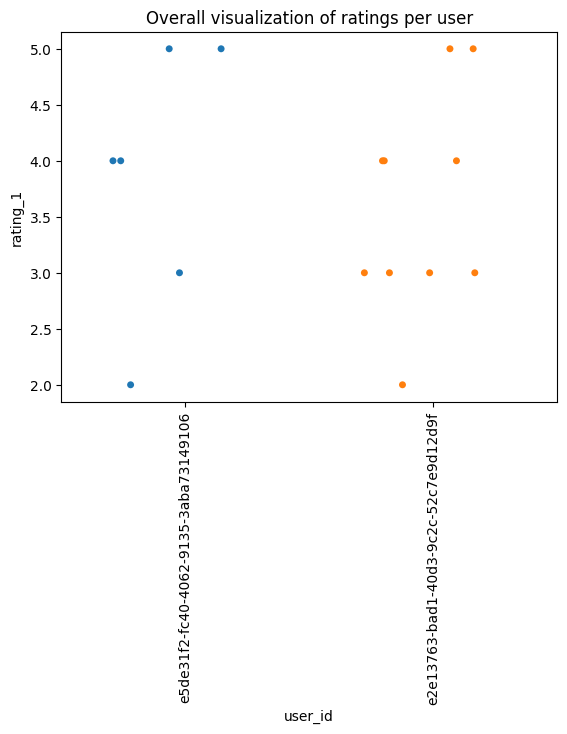

In [21]:
import seaborn as sns
from matplotlib import pyplot as plt 

n_users = len(ratings["user_id"].unique())
print(f"There are {n_users} users")

sns.stripplot(ratings, x="user_id", y="rating_1", jitter=0.3, hue="user_id")
plt.xticks(rotation=90)

sns.stripplot(ratings, x="user_id", y="rating_2", jitter=0.3, hue="user_id")
plt.xticks(rotation=90)

plt.title("Overall visualization of ratings per user")
plt.show()

In [22]:
ratings_per_user = ratings.groupby("user_id")["id"].count()
df_ratings_per_user = pd.DataFrame.from_dict(
    {"user_id": ratings_per_user.index, "count": ratings_per_user.values}
).sort_values("count", ascending=False)
df_ratings_per_user

,user_id,count
0,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f,5
1,e5de31f2-fc40-4062-9135-3aba73149106,3


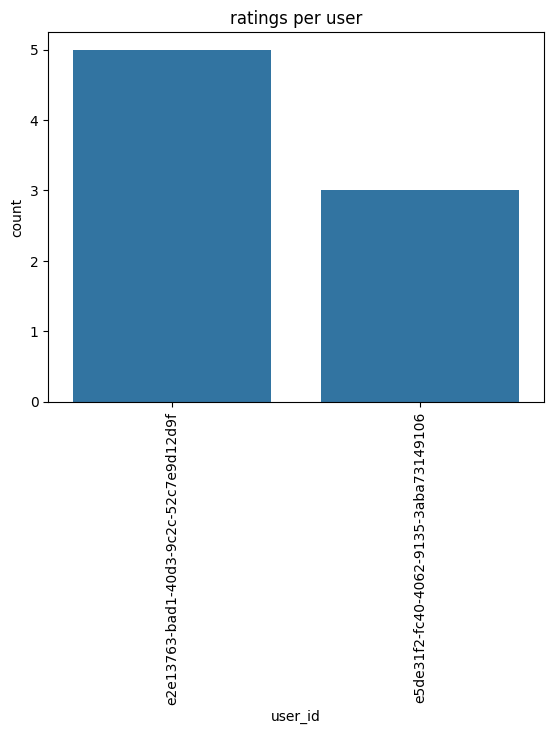

In [23]:
sns.barplot(df_ratings_per_user, x="user_id", y="count")
plt.xticks(rotation=90)
plt.title("ratings per user")
plt.show()

### How many times has every individual model been rated?

In [24]:
rating_records = []

for idx, row in ratings.iterrows():
    pair = pairs[row["pair_id"] == pairs["id"]].iloc[0]
    rating_records.append(
        {
            "model_name": str(pair["model_1"])
            .replace("splats/", "")
            .replace(".ksplat", ""),
            "rating": row["rating_1"],
            "user_id": row["user_id"],
        }
    )
    rating_records.append(
        {
            "model_name": str(pair["model_2"])
            .replace("splats/", "")
            .replace(".ksplat", ""),
            "rating": row["rating_2"],
            "user_id": row["user_id"],
        }
    )

df_ratings_per_model = pd.DataFrame.from_records(rating_records)
df_ratings_per_model

,model_name,rating,user_id
0,mcmc-stump-medium-1,4,e5de31f2-fc40-4062-9135-3aba73149106
1,eagles-stump-medium-1,4,e5de31f2-fc40-4062-9135-3aba73149106
2,mini_splatting-room-high-1,3,e5de31f2-fc40-4062-9135-3aba73149106
3,gaussian_pro-room-high-1,2,e5de31f2-fc40-4062-9135-3aba73149106
4,mini_splatting-truck-medium-1,3,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f
5,eagles-truck-medium-1,5,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f
6,mini_splatting-room-low-1,2,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f
7,mip_splatting-room-low-1,4,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f
8,mini_splatting-stump-medium-1,5,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f
9,eagles-stump-medium-1,3,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f


In [25]:
count_ratings_per_model = df_ratings_per_model.groupby("model_name")["model_name"].count()
df_count_ratings_per_model = pd.DataFrame.from_dict({
    "model_name": count_ratings_per_model.index,
    "n_ratings": count_ratings_per_model.values,
}).sort_values("n_ratings", ascending=False)
df_count_ratings_per_model

,model_name,n_ratings
1,eagles-stump-medium-1,2
9,mini_splatting-room-high-1,2
2,eagles-truck-high-1,1
3,eagles-truck-medium-1,1
4,gaussian_pro-room-high-1,1
0,eagles-stump-high-1,1
5,gaussian_pro-stump-high-1,1
6,geo_gaussian-room-high-1,1
7,geo_gaussian-truck-high-1,1
8,mcmc-stump-medium-1,1


### Whats the mean opinion score (MOS) per dataset, per model, per size? (assuming truck dataset for now)

In [26]:
df_ratings_per_model["model"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[0]
)
df_ratings_per_model["dataset"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[1]
)
df_ratings_per_model["size"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[2]
)
df_ratings_truck = df_ratings_per_model[df_ratings_per_model["dataset"] == "truck"]
df_grouped = (
    df_ratings_truck.groupby(["model", "dataset", "size"])
    .agg({"rating": "mean"})
    .reset_index()
)
df_grouped["n_splats"] = df_grouped["size"].apply(
    lambda size: {
        "low": 117856,
        "medium": 412235,
        "high": 1093135,
        "extended": 2186270,
    }[size]
)
df_grouped

,model,dataset,size,rating,n_splats
0,eagles,truck,high,5.0,1093135
1,eagles,truck,medium,5.0,412235
2,geo_gaussian,truck,high,5.0,1093135
3,mini_splatting,truck,medium,3.0,412235


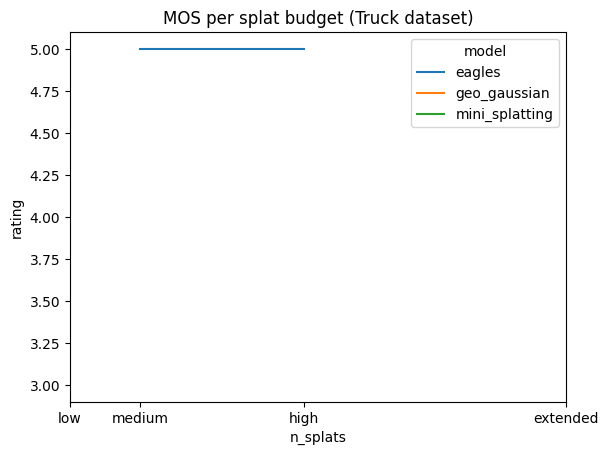

In [27]:
ax = plt.subplot()
sns.lineplot(df_grouped, x="n_splats", y="rating", hue="model", ax=ax)
plt.title("MOS per splat budget (Truck dataset)")
ax.set_xticks([117856, 412235, 1093135, 2186270], ["low", "medium", "high", "extended"])
plt.show()

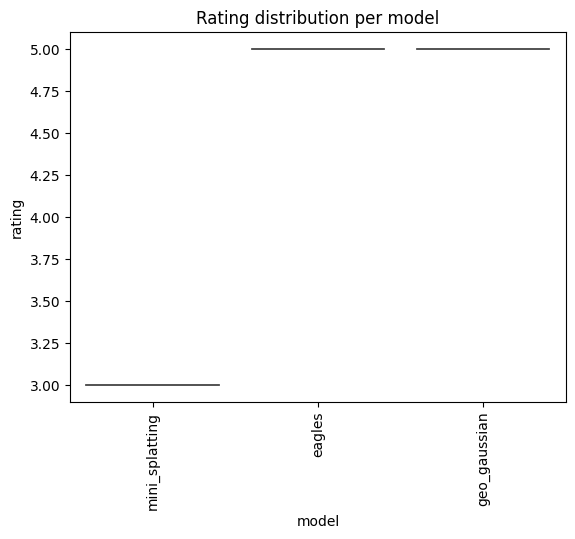

In [28]:
sns.violinplot(df_ratings_truck, x="model", y="rating", hue="model")
plt.title("Rating distribution per model")
plt.xticks(rotation=90)
plt.show()